In [1]:
#imports
import numpy as np
import pandas as pd
import random
import string

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import csv
import datetime
from datetime import timedelta,datetime, date

from scipy import stats

from catboost import CatBoostClassifier, Pool
from catboost import utils
import catboost

import pickle

import sklearn
from sklearn import metrics

In [2]:
cu = pd.read_parquet("customers.parquet")
tr = pd.read_parquet("transactions_2_cleaned.parquet")

In [3]:
exptypes = tr.EXP_TYPE.cat.categories.to_list()
prodtypes = cu.PROD_TYPE.cat.categories.to_list()

cutoprod = {c:v.PROD_TYPE for (c,v) in cu.groupby("CUST_ID")}

In [4]:
grp = tr.loc[:, ["CUST_ID", "EXP_TYPE", "AMOUNT"]].groupby("CUST_ID")
l = []
lcu = []

for (k,v) in grp:
  df2 = v.groupby("EXP_TYPE").apply(lambda x: pd.Series([x.shape[0], 
    x.AMOUNT.sum()], index= ["n", "AMOUNT"]))
  df2.loc[:, "AMOUNT_prop"] = df2.AMOUNT / df2.AMOUNT.sum()
  df2.loc[:, "n_prop"] = df2.n / df2.n.sum()
  df2.loc[:, "AMOUNT_per_n"] = [0.0 if np.isnan(x) else x  
                                for x in df2.AMOUNT / df2.n]
  l.append(df2)
  lcu.append(k)

In [5]:
nc = len(exptypes)
datax = np.zeros((len(l), 3*len(exptypes)))
for (i,v) in enumerate(l):
  datax[i, range(nc)] = v.AMOUNT_prop
  datax[i, range(nc, nc + nc)] = v.n_prop
  datax[i, range(2*nc, 2*nc + nc)] = v.AMOUNT_per_n

datay = [ np.array([float((p == cutoprod[cu]).any())  for cu in lcu]) 
         for p in prodtypes]

In [6]:
def calc_threshold_stats(pr, gt):
  fpr = [];   tpr = [];   thr = np.linspace(0., 1., 101);   prec = [];  recall = []
  for t in thr:
    prl = pr >= t
    fpr.append(np.logical_not(gt[prl]).sum() / np.logical_not(gt).sum())
    tpr.append(gt[prl].sum() / gt.sum())
    recall.append(gt[prl].sum() / gt.sum())
    prec.append(gt[prl].sum() / prl.sum()  if prl.sum() > 0 else 0.)
  return((fpr, tpr, thr, recall, prec))
  
def gen_crossval_indecies(df, kfold):
  n = df.shape[0]
  return(np.random.permutation([int(x // (n/5))  for x in range(n)]))

def catboost_train(datax, datay):
  model = CatBoostClassifier(loss_function= 'CrossEntropy')
  model.fit(datax, datay, verbose= False)
  return(model)

def catboost_train_and_eval(datax, datay, trainii, testii):
  model = catboost_train(datax[trainii, :], datay[trainii])
  
  pr = model.predict(datax[testii, :]) == 1.
  gt = datay[testii] == 1.
  
  acc = (pr == gt).mean()
  prec = (pr == gt)[pr].sum() / pr.sum()
  recall = (pr == gt)[gt].sum() / gt.sum()
  f1 = 2*prec*recall / (prec + recall)
  
  (fpr, tpr, thresholds, trecall, tprec) = calc_threshold_stats(
    [x[1]   for x in model.predict_proba(datax[testii, :])], gt)
  #pl = Pool(datax[testii, :], datay[testii])
  #curve = catboost.utils.get_roc_curve(model, pl)
  #(fpr, tpr, thresholds)= curve
  rocauc= sklearn.metrics.auc(fpr, tpr)
  
  return( {"acc": acc, "prec": prec, "recall": recall, "f1": f1, 
           "fpr": fpr, "tpr": tpr, "thresholds": thresholds, "trecall": trecall,
           "tprec": tprec, "model": model, "rocauc": rocauc} )

def catboost_train_and_eval_cv(datax, datay, kfold):
  cvii = gen_crossval_indecies(datax, kfold)
  ra = {"acc": [], "prec": [], "recall": [], "f1": [], 
        "fpr": [], "tpr": [], "thresholds": [], "trecall": [],
        "tprec": [], "model": [], "rocauc": []}
  for cvi in range(kfold):
    r = catboost_train_and_eval(datax, datay, cvii != cvi, cvii == cvi)
    for x in ra:
      ra[x].append(r[x])
  
  return(ra)

In [7]:
r = [catboost_train_and_eval_cv(datax, datay[i], 5)  
     for i in range(len(prodtypes))]

In [8]:
lst = []
for i in range(len(prodtypes)):
  d = {"prodtype": prodtypes[i]}
  for x in ["acc", "prec", "recall", "f1", "rocauc"]:
    d[x] = np.mean(r[i][x])
    d[x + "_std"] = np.std(r[i][x])

  for j in range(5):
    for x in ["acc", "prec", "recall", "f1", "rocauc"]:
      d["{}{}".format(x, j)] = r[i][x][j]
  lst.append(d)
  
dfres1 = pd.DataFrame(lst)
dfres1.to_excel("outputs/5_catboost_accs.xlsx", index= False)
dfres1

,prodtype,acc,acc_std,prec,prec_std,recall,recall_std,f1,f1_std,rocauc,...,acc3,prec3,recall3,f13,rocauc3,acc4,prec4,recall4,f14,rocauc4
0,Автокредитование,0.910422,0.005637,0.878073,0.030985,0.457928,0.029732,0.601463,0.029101,0.920376,...,0.912049,0.852349,0.456835,0.594848,0.918705,0.920691,0.902439,0.513889,0.654867,0.939875
1,Вклады,0.912964,0.006163,0.917955,0.012921,0.734568,0.021002,0.815890,0.014332,0.952487,...,0.922217,0.924051,0.747951,0.826727,0.956617,0.904931,0.920200,0.704198,0.797838,0.941015
2,Инвестиции,0.936553,0.004773,0.939172,0.015013,0.525496,0.022575,0.673693,0.020539,0.939899,...,0.945094,0.957143,0.567797,0.712766,0.947164,0.935435,0.939850,0.512295,0.663130,0.937893
3,Кредиты,0.927300,0.002894,0.941232,0.013997,0.672265,0.009451,0.784308,0.010482,0.956734,...,0.924250,0.943463,0.667500,0.781845,0.955353,0.928826,0.940959,0.672823,0.784615,0.956914
4,"Лайфстайл (бронирование столиков, покупка биле...",0.953025,0.002147,0.928102,0.032051,0.608990,0.026565,0.735316,0.028273,0.952135,...,0.954753,0.950000,0.618605,0.749296,0.966883,0.952720,0.921053,0.633484,0.750670,0.953476
5,Накопительные счета,0.889985,0.005537,0.914030,0.012757,0.597689,0.011217,0.722670,0.009235,0.933141,...,0.892222,0.911184,0.599567,0.723238,0.932287,0.884087,0.902280,0.583158,0.708440,0.926727
6,Прайват обслуживание,0.957702,0.001086,0.899893,0.036836,0.108647,0.031560,0.192674,0.051520,0.878432,...,0.959329,0.833333,0.059524,0.111111,0.876581,0.956279,0.937500,0.150000,0.258621,0.864740
7,Премиальное обслуживание,0.960041,0.004565,0.943389,0.055051,0.308302,0.022423,0.463682,0.024430,0.902804,...,0.966446,0.970588,0.336735,0.500000,0.920551,0.959329,0.833333,0.324074,0.466667,0.886329
8,Страхование,0.950991,0.006140,0.917572,0.014621,0.534914,0.050716,0.674454,0.043482,0.935700,...,0.955262,0.907407,0.556818,0.690141,0.936962,0.957804,0.943396,0.564972,0.706714,0.945248
9,Услуги для бизнеса,0.950788,0.004085,0.940468,0.033587,0.387893,0.022916,0.548382,0.018660,0.919104,...,0.950178,0.935484,0.381579,0.542056,0.919860,0.951195,0.966102,0.377483,0.542857,0.934816


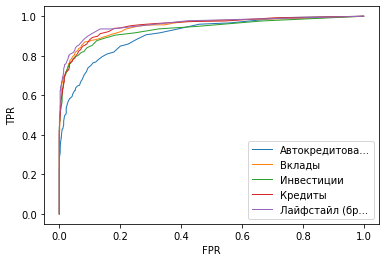

In [9]:
stripstr = lambda x: x if len(x) < 15 else x[0:13] + "..."

for i in range(0,5):
  plt.plot(r[i]["fpr"][0], r[i]["tpr"][0], label= stripstr(dfres1.prodtype[i]), 
           lw=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.savefig("outputs/6_catboost_aucs-1.png", dpi= 600, transparent= False, 
  facecolor= "white", backend= "cairo", bbox_inches= "tight")

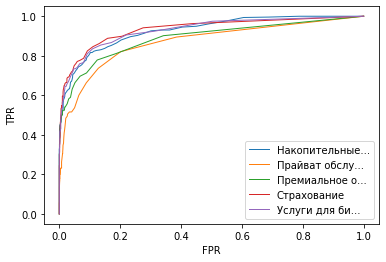

In [10]:
for i in range(5,10):
  plt.plot(r[i]["fpr"][0], r[i]["tpr"][0], label= stripstr(dfres1.prodtype[i]), 
           lw=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.savefig("outputs/6_catboost_aucs-2.png", dpi= 600, transparent= False, 
  facecolor= "white", backend= "cairo", bbox_inches= "tight")

In [11]:
modelsfinals = [catboost_train(datax, datay[i])   for i in range(len(prodtypes))]

for (i,x) in enumerate(modelsfinals):
  x.save_model("catboost_p{}.cbm".format(i))

In [12]:
thresh = r[0]["thresholds"][0]
prec = []
recall = []

for i in range(len(r)):
  prec.append(np.mean(np.array(r[i]["tprec"]), axis= 0))
  recall.append(np.mean(np.array(r[i]["trecall"]), axis= 0))

pickle.dump((thresh, prec, recall), open("catboost_thr.pickle", "wb"))